<a href="https://colab.research.google.com/github/lqmanalhakim/Housing-System/blob/main/HousingSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LUQMAN ALHAKIM BIN YAZID
2019079

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq> /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.4/spark-3.3.4-bin-hadoop3.tgz

In [ ]:
!tar xf spark-3.3.4-bin-hadoop3.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.4-bin-hadoop3"

In [ ]:
!pip install -q findspark
import findspark
findspark.init()
findspark.find()

'/content/spark-3.3.4-bin-hadoop3'

In [ ]:
from pyspark.sql.functions import col

**Importing the Data**

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('American_Housing_System').getOrCreate()

In [ ]:
#loading growth_from_industry_transition  dataset
Housing_System = spark.read.csv('housdata.csv', header=True, inferSchema=True)
Housing_System = Housing_System.select("NUNITS","FMTBUILT","FMTOWNRENT","FMR","REGION","FMTSTRUCTURETYPE","ZINC2","UTILITY","INCRELAMICAT","VALUE","OTHERCOST","INCRELAMIPCT")
Housing_System.show()

+------+-----------+----------+----+------+-----------------+------+-----------+------------+------+-----------+------------+
|NUNITS|   FMTBUILT|FMTOWNRENT| FMR|REGION| FMTSTRUCTURETYPE| ZINC2|    UTILITY|INCRELAMICAT| VALUE|  OTHERCOST|INCRELAMIPCT|
+------+-----------+----------+----+------+-----------------+------+-----------+------------+------+-----------+------------+
|     1|'2000-2009'| '1 Owner'|1095|   '1'|'1 Single Family'| 65250|229.1666667|           6| 50000|      310.0| 113.6300311|
|     1|'2000-2009'| '1 Owner'|1095|   '1'|'1 Single Family'| 35400|355.4166667|           4|238000|     222.75| 70.45435095|
|     1|'1980-1989'| '1 Owner'| 965|   '3'|'1 Single Family'| 74932|      199.0|           7|200000|79.16666667| 139.0926641|
|     1|'1980-1989'| '1 Owner'| 861|   '3'|'1 Single Family'| 30950|      173.0|           4|175000|        0.0| 71.81374369|
|     8|'1980-1989'|'2 Renter'| 685|   '3'|   '3 5-19 units'| 15600|      113.0|           2|    -6|        9.0| 31.93

**Data Processing**

In [ ]:
#Checking for null values
from pyspark.sql.functions import col, sum

# Checking for null values
Housing_System_null = Housing_System.select([sum(col(c).isNull().cast("int")).alias(c) for c in Housing_System.columns])

Housing_System_null.show()

+------+--------+----------+---+------+----------------+-----+-------+------------+-----+---------+------------+
|NUNITS|FMTBUILT|FMTOWNRENT|FMR|REGION|FMTSTRUCTURETYPE|ZINC2|UTILITY|INCRELAMICAT|VALUE|OTHERCOST|INCRELAMIPCT|
+------+--------+----------+---+------+----------------+-----+-------+------------+-----+---------+------------+
|     0|       0|         0|  0|     0|               0|    0|      0|           0|    0|        0|           0|
+------+--------+----------+---+------+----------------+-----+-------+------------+-----+---------+------------+



In [ ]:
Housing_System = Housing_System.dropna()

In [ ]:
# checking for duplicate values
Housing_System_duplicate = Housing_System.groupBy(Housing_System.columns).count().filter(col('count') > 1).count()

# Print the number of duplicated rows
print("There are {} duplicated rows in the dataset.".format(Housing_System_duplicate))

# Drop duplicates and get the new row count
Housing_System = Housing_System.dropDuplicates()
row_count = Housing_System.count()

# Print the number of rows after dropping duplicates
print("Number of rows after dropping duplicates is {}.".format(row_count))

There are 10 duplicated rows in the dataset.
Number of rows after dropping duplicates is 9113.


**EDA**

**ANALYSIS**

In [ ]:
Housing_System_filtered = Housing_System.filter(col("NUNITS") >= 0)

What is the most unit built in a specific year? (NUNITS, FMTBUILT)

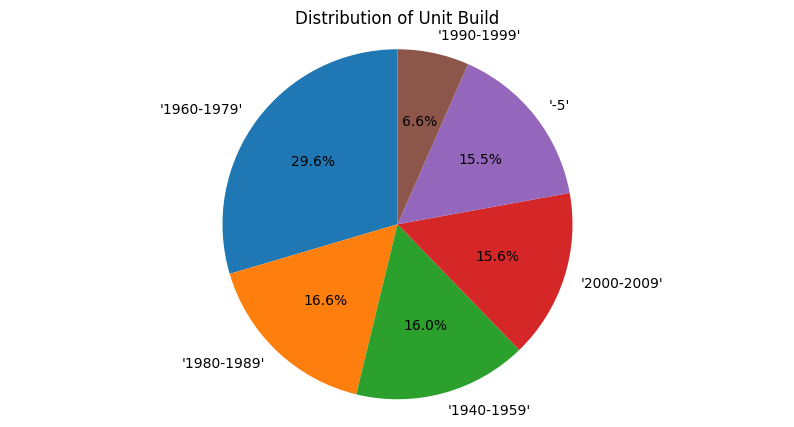

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
plt.show()

House_counts = Housing_System_filtered.groupBy("FMTBUILT").count().orderBy(F.desc("count")).toPandas()
House_labels = House_counts["FMTBUILT"]
House_sizes = House_counts["count"]

# Create a pie chart
plt.figure(figsize=(10, 5))
plt.pie(House_sizes, labels=House_labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Distribution of Unit Build")
plt.show()


What are the percentage of Renter and Owner? (FMTOWNRENT)

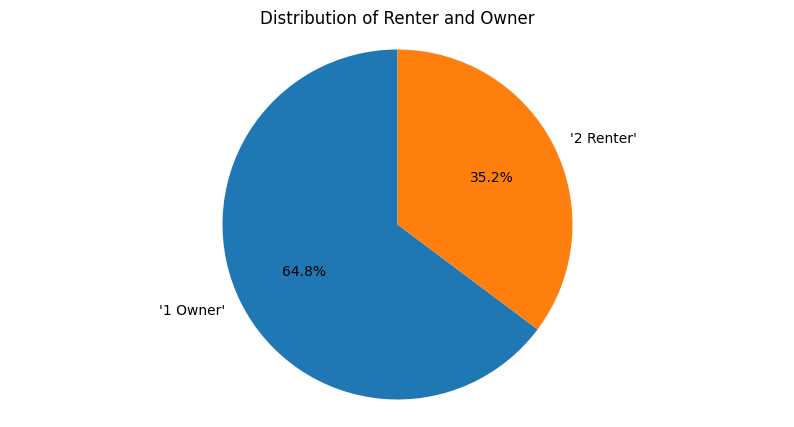

In [ ]:
RenterOwner_counts = Housing_System_filtered.groupBy("FMTOWNRENT").count().orderBy(F.desc("count")).toPandas()
RenterOwner_labels = RenterOwner_counts["FMTOWNRENT"]
RenterOwner_sizes = RenterOwner_counts["count"]

# Create a pie chart
plt.figure(figsize=(10, 5))
plt.pie(RenterOwner_sizes, labels=RenterOwner_labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Distribution of Renter and Owner")
plt.show()

What are the Fair Market Rent (FMR) values for housing in each respective region? (FMR, REGION)

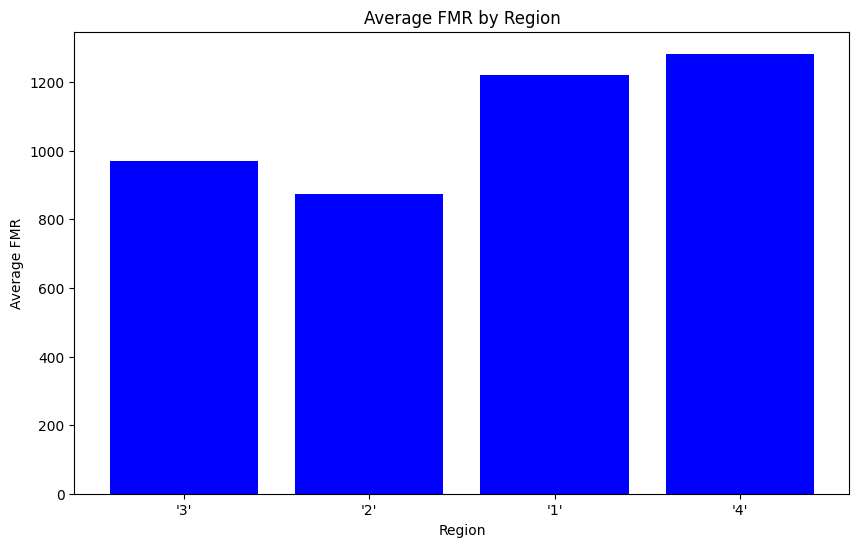

In [ ]:
# Group by region and calculate the average FMR
average_fmr_by_region = Housing_System.groupBy("REGION").agg(F.avg("FMR").alias("AverageFMR"))

# Convert the result to Pandas for plotting
average_fmr_pd = average_fmr_by_region.toPandas()

# Plot the average FMR for each region
plt.figure(figsize=(10, 6))
plt.bar(average_fmr_pd["REGION"], average_fmr_pd["AverageFMR"], color='blue')
plt.xlabel('Region')
plt.ylabel('Average FMR')
plt.title('Average FMR by Region')
plt.show()

Does house owner prefer one unit of buliding or multiple unit of building? (FMTOWNRENT, NUNITS)

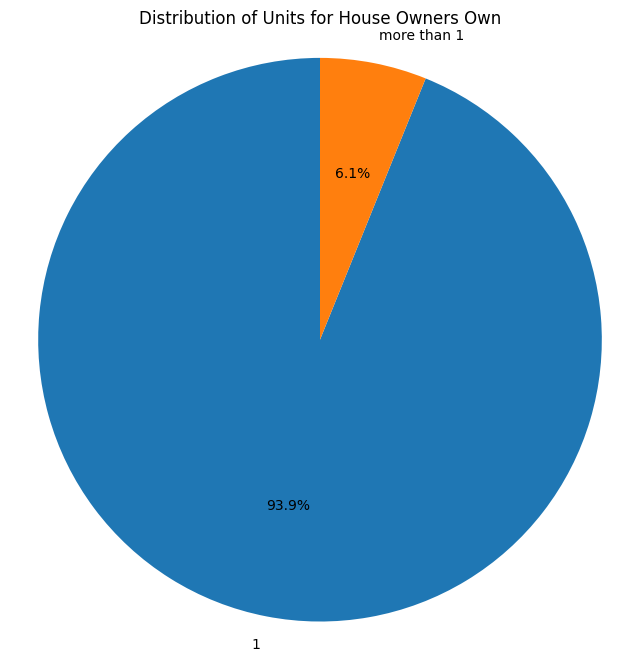

In [ ]:
# Filter the data for house owners and select relevant columns
owner_data = Housing_System.filter(col("FMTOWNRENT") == "'1 Owner'").select("FMTOWNRENT", "NUNITS")

# Classify NUNITS into two classes: "1" and "more than 1"
owner_data_classified = owner_data.withColumn("NUNITS_CLASS", F.when(col("NUNITS") == 1, "1").otherwise("more than 1"))

# Calculate the distribution of unit classes
unit_class_counts = owner_data_classified.groupBy("NUNITS_CLASS").count().orderBy("NUNITS_CLASS").toPandas()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(unit_class_counts["count"], labels=unit_class_counts["NUNITS_CLASS"], autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Units for House Owners Own')
plt.show()

In [ ]:
print(owner_data)


DataFrame[FMTOWNRENT: string, NUNITS: int]


How does the total of income sources influence the choice of residential buildings individuals prefer to reside in? (FMTSTRUCTURETYPE, ZINC2)

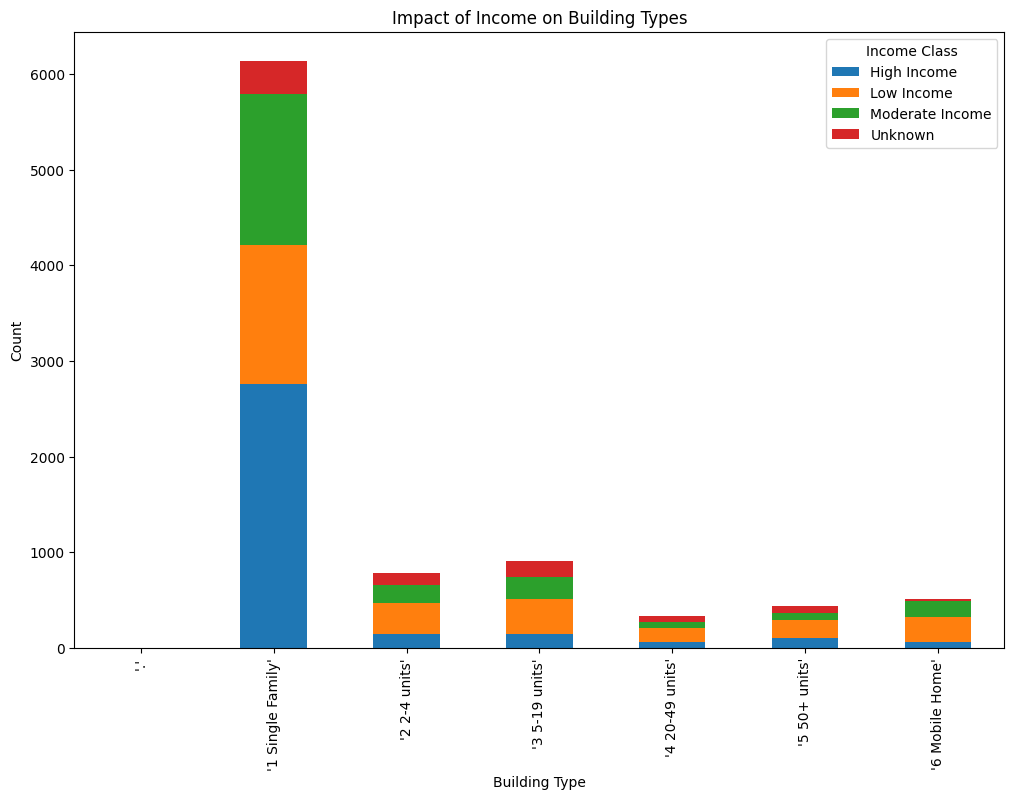

In [ ]:
# Adjust the income ranges based on your specific requirements
income_classified = Housing_System.withColumn(
    "INCOME_CLASS",
    F.when((col("ZINC2") >= 0) & (col("ZINC2") < 30000), "Low Income")
    .when((col("ZINC2") >= 30000) & (col("ZINC2") < 60000), "Moderate Income")
    .when(col("ZINC2") >= 60000, "High Income")
    .otherwise("Unknown")
)

# Group by the building type and income class, and count the occurrences
building_income_counts = income_classified.groupBy("FMTSTRUCTURETYPE", "INCOME_CLASS").count().orderBy("FMTSTRUCTURETYPE").toPandas()

# Pivot the data for better visualization
pivot_data = building_income_counts.pivot(index='FMTSTRUCTURETYPE', columns='INCOME_CLASS', values='count').fillna(0)

# Plot side-by-side bar graphs
fig, ax = plt.subplots(figsize=(12, 8))
pivot_data.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Building Type')
ax.set_ylabel('Count')
ax.set_title('Impact of Income on Building Types')
plt.legend(title='Income Class')
plt.show()

What is the median saving for renters and owners so they can sustain their livelihood in each region? (UTILITY, REGION)

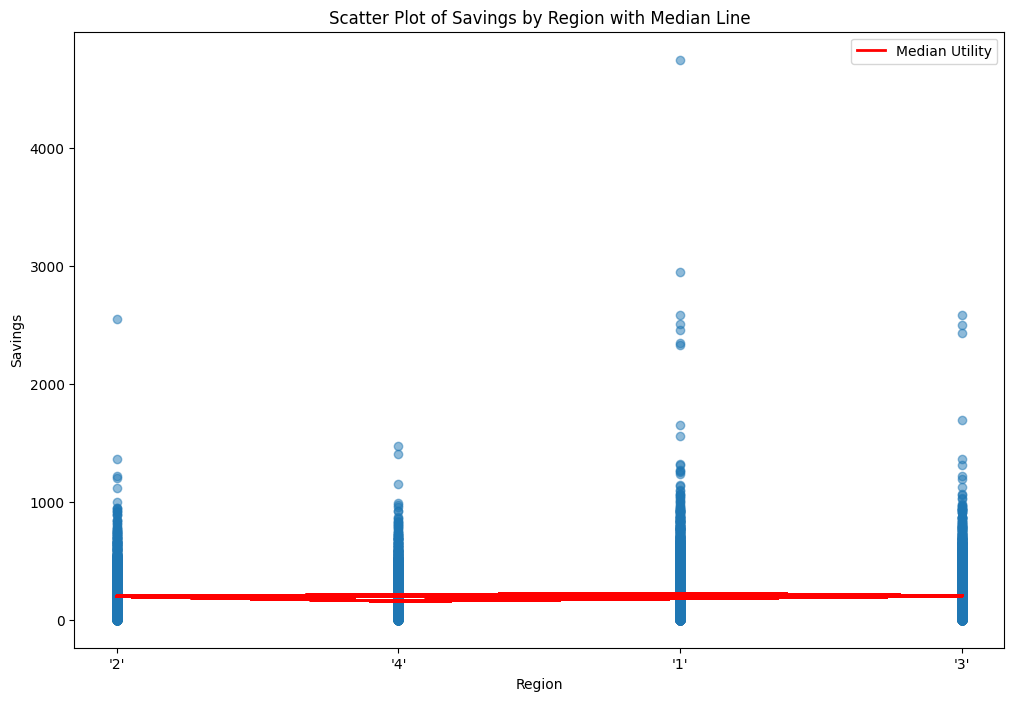

In [ ]:
# Calculate the median utility by region
median_utility_by_region = Housing_System.groupBy("REGION").agg(F.expr("percentile_approx(UTILITY, 0.5)").alias("MedianUtility"))

# Join the median utility with the original data
joined_data = Housing_System.join(median_utility_by_region, "REGION")

# Add a new column "OTHERCOST" as the sum of "UTILITY" and another column (replace with your actual column name)
joined_data = joined_data.withColumn("SAVINGS", F.col("UTILITY") + F.col("OTHERCOST"))

# Convert the Spark DataFrame to Pandas for plotting
pandas_data = joined_data.toPandas()

# Plot the scatter plot with median line
plt.figure(figsize=(12, 8))
plt.scatter(pandas_data["REGION"], pandas_data["SAVINGS"], alpha=0.5)
plt.plot(pandas_data["REGION"], pandas_data["MedianUtility"], color='red', label='Median Utility', linewidth=2)
plt.xlabel('Region')
plt.ylabel('Savings')
plt.title('Scatter Plot of Savings by Region with Median Line')
plt.legend()
plt.show()

How does the distribution of household income relative to the Area Median Income (AMI) vary across region? (INCRELAMIPCT, INCRELAMICAT, REGION)

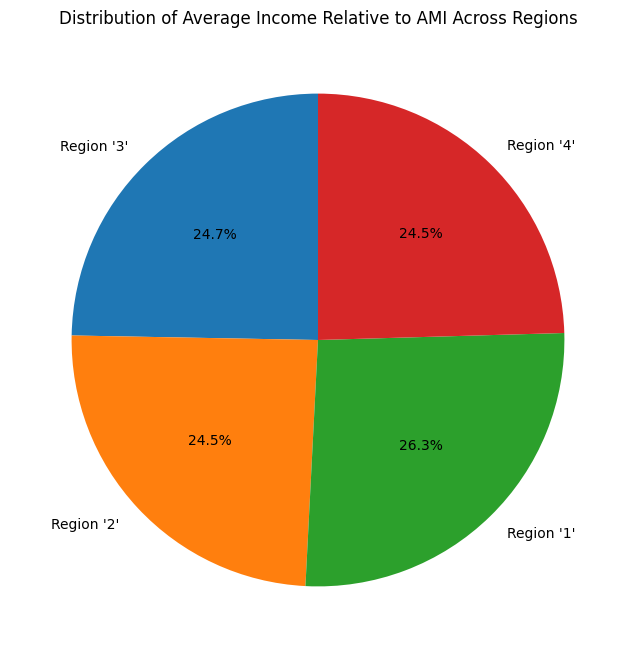

In [ ]:
# Select relevant columns
selected_data = Housing_System.select("INCRELAMIPCT", "REGION")

# Group by region and calculate the average income relative to AMI
average_income_by_region = selected_data.groupBy("REGION").agg(F.avg("INCRELAMIPCT").alias("AverageINCRELAMIPCT"))

# Convert the Spark DataFrame to Pandas for easier plotting
pandas_data = average_income_by_region.toPandas()

# Plot a single pie chart for all regions
plt.figure(figsize=(8, 8))

# Ensure values are within the valid range for a pie chart
values = pandas_data["AverageINCRELAMIPCT"].tolist()
labels = [f'Region {region}' for region in pandas_data["REGION"]]

plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Average Income Relative to AMI Across Regions')
plt.show()

Is the market value of a housing unit influenced by the type of building it is ? (VALUE, FMTSTRUCTURETYPE)

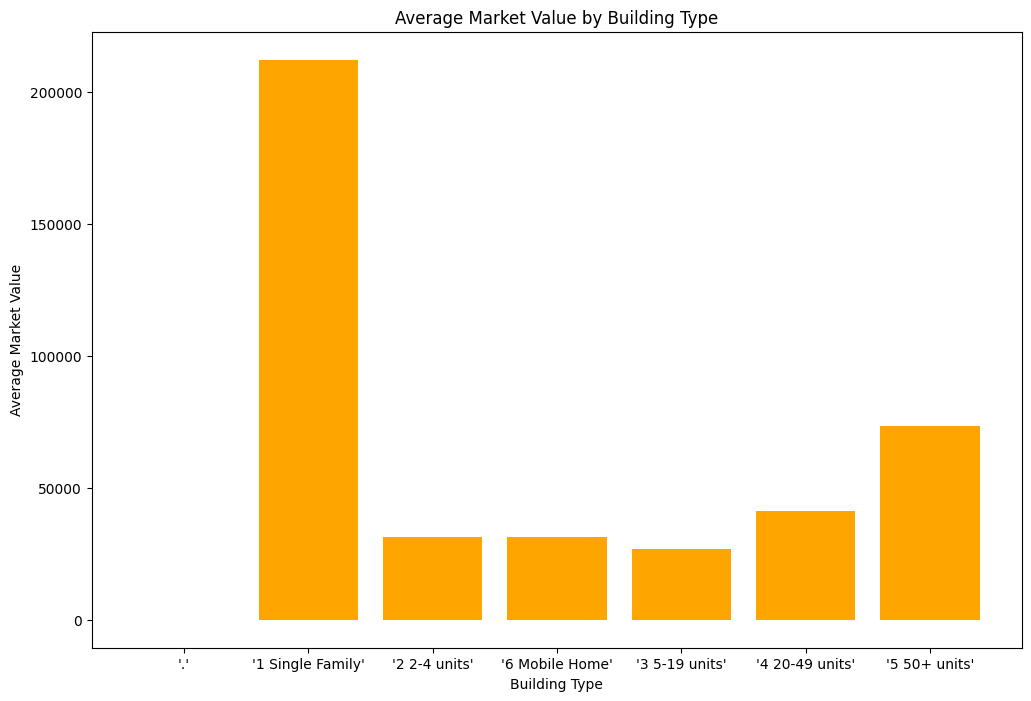

In [ ]:
# Select relevant columns
selected_data = Housing_System.select("VALUE", "FMTSTRUCTURETYPE")

# Group by building type and calculate the average market value
average_value_by_building_type = selected_data.groupBy("FMTSTRUCTURETYPE").agg(F.avg("VALUE").alias("AverageValue"))

# Convert the Spark DataFrame to Pandas for easier plotting
pandas_data = average_value_by_building_type.toPandas()

# Plot a bar graph
plt.figure(figsize=(12, 8))
plt.bar(pandas_data["FMTSTRUCTURETYPE"], pandas_data["AverageValue"], color='Orange')
plt.xlabel('Building Type')
plt.ylabel('Average Market Value')
plt.title('Average Market Value by Building Type')
plt.show()